# Customer Retention Clustering Using KMEANS and GMM

In [1]:
import os
import joblib
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import BayesianGaussianMixture
from sklearn.svm import SVC

In [2]:
%pip install imbalanced-learn

import imblearn.pipeline as pl
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, SVMSMOTE

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\willl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
plt.style.use('seaborn-v0_8-bright')
%matplotlib inline

In [6]:
DATA_DIR = os.getcwd()

## Synopsis

  > We are going to try and predict customer retention.  There are many models and many transforms to consider.  
    
  > Marketing is asking for a report on customer retention that can be used to improve current marketing strategy.  The current plan is for marketing at AAVAiL to collect more features on subscribers and they would like to use the report as a proof-of-concept in order to get buy-in for this effort.
  
## Outline

1. Create a churn prediction baseline model
2. Use clustering as part of your prediction pipeline
3. Run and experiment to see if re-sampling techniques improve your model

## Data

Here we load the data `aavail-target.csv`

In [7]:
df = pd.read_csv(os.path.join(DATA_DIR, r"aavail-target.csv"))

## pull out the target and remove uneeded columns
_y = df.pop('is_subscriber')
y = np.zeros(_y.size)
y[_y==0] = 1 
df.drop(columns=['customer_id', 'customer_name'], inplace=True)
df.head()

,country,age,subscriber_type,num_streams
0,united_states,21,aavail_premium,23
1,singapore,30,aavail_unlimited,12
2,united_states,21,aavail_premium,22
3,united_states,20,aavail_basic,19
4,singapore,21,aavail_premium,23


### Part 1

Using the train_test_split() function, create a stratified train test split of the data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=42)

### Part 2

Create a baseline model.  Test whether clustering followed by a model improves the results.  Then, we will test whether re-sampling techniques provide improvements.

In [9]:
## preprocessing pipeline
numeric_features = ['age', 'num_streams']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['country', 'subscriber_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encod', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [24]:
# Create an instance of a binary classifier
clf = RandomForestClassifier(random_state=42)

# Create a Pipeline that binds the preprocessing transformer and the classifier estimator.

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', clf)])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# predict the dependent variable of the test set.
y_pred = pipe.predict(X_test)

# Print the f1_score of the prediction.
print("f1_score", f1_score(y_test, y_pred, average='binary'))

f1_score 0.5739130434782609


In [ ]:
# To improve the performance of the model add a gridsearch on the pipeline
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15, 20]
}

# Create a GridSearchCV object
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid.fit(X_train, y_train)

# predict the dependent variable of the test set.
y_pred = grid.predict(X_test)

# Print the f1_score of the prediction.
print("f1_score", f1_score(y_test, y_pred, average='binary'))

# Print the best parameters of the gridsearch
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)


f1_score 0.6153846153846154
Best parameters:  {'classifier__max_depth': 5, 'classifier__n_estimators': 50}
Best score:  0.7725
Best estimator:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'num_streams']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                     

### Part 3

The next part is to create a version of the classifier that uses identified clusters.  In this example 4 clusters were specified and their one-hot encoded versions were appended to the feature matrix.  Now using pipelines to compare the performance using cluster profiling as part of the matrix to the baseline. 

In [27]:
class KmeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=4):
        self.n_clusters = n_clusters
        self.km = KMeans(n_clusters=self.n_clusters, n_init=20)
        
    def transform(self, X, *_):
        labels = self.km.predict(X)
        return np.hstack((X, labels.reshape(-1, 1)))

    def fit(self, X, y=None, *_):
        self.km.fit(X)
        labels = self.km.predict(X)
        self.silhouette_score = round(silhouette_score(X, labels, metric='mahalanobis'), 3)
        return self

class GmmTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=4):
        self.n_clusters = n_clusters
        self.gmm = BayesianGaussianMixture(n_components=self.n_clusters, covariance_type='full',
                                           max_iter=500, n_init=10, warm_start=True)        
    def transform(self, X,*_):
        probs = self.gmm.predict_proba(X) + np.finfo(float).eps
        return np.hstack((X, probs))
        
    def fit(self, X, y=None, *_):
        self.gmm.fit(X)
        labels = self.gmm.predict(X)
        self.silhouette_score = round(silhouette_score(X, labels, metric='mahalanobis'), 3)
        return self
    
## example for kmeans
preprocessor.fit(X_train)
X_train_pre = preprocessor.transform(X_train)    
kt = KmeansTransformer(4)
kt.fit(X_train_pre)
X_train_kmeans = kt.transform(X_train_pre)
print(X_train_pre.shape)
print(X_train_kmeans.shape)   
    
## example for GMM  
preprocessor.fit(X_train)
X_train_pre = preprocessor.transform(X_train)    
gt = GmmTransformer(4)
gt.fit(X_train_pre)
X_train_gmm = gt.transform(X_train_pre)
print(X_train_pre.shape)  
print(X_train_gmm.shape)

(800, 4)
(800, 5)
(800, 4)
(800, 8)


In [36]:
def run_clustering_pipeline(umodel):
    """
    This function evaluates different Pipelines constituted of the preprocessing transformer,
    a clustering transformer and a classifier estimator.
    INPUT : The name of the clustering transformer : 'gmm' or 'kmeans'
    OUTPUT : The list of f1_scores of the pipeline on the test set for the different number of clusters
    """
    
    fscores = [] # this list will store the f1_score of the different models that we will train
    for n_clusters in np.arange(3, 8):
    
        # Create an instance of a binary classifier (The same as the one you trained in the previous question)
        estimator = RandomForestClassifier()
        param_grid = {
                        'n_estimators': [25, 50, 75],
                        'max_depth': [4, 5, 7],
                        'criterion': ['gini', 'entropy']
                    }
        clf = GridSearchCV(estimator, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')
        
        if umodel == 'gmm':
            # Create an instance of the Gmm transformer with n_clusters clusters
            cluster = GmmTransformer(n_clusters)    
        elif umodel == 'kmeans':
            # Create an instance of the Kmean transformer with n_clusters clusters
            cluster = KmeansTransformer(n_clusters)
        else:
            raise Exception("invalid unsupervised learning model")
        
        # Create a Pipeline that binds the preprocessing transformer, the clustering transformer and the classifier
        pipe = Pipeline(steps=[('pre', preprocessor),
                               ('clustering', cluster),
                               ('classifier', clf)])  
        
        # Fit the pipeline on training set
        pipe.fit(X_train, y_train)
        # Predict the test set
        y_pred = pipe.predict(X_test)
        # Compute the f1 score and add this score to the fscores list.
        score = round(f1_score(y_test, y_pred, average='binary'), 3)
        fscores.append(score)
        
    return fscores

## Run the different iteration of the model
cp_results = {}
cp_results['kmeans'] = run_clustering_pipeline('kmeans')
cp_results['gmm'] = run_clustering_pipeline('gmm')

## Display table of results
df_cp = pd.DataFrame(cp_results)
df_cp["n_clusters"] = [str(i) for i in np.arange(3,8)]
df_cp.set_index("n_clusters", inplace=True)
df_cp.head(n=10)

,kmeans,gmm
n_clusters,,
3,0.602,0.631
4,0.602,0.608
5,0.615,0.610
6,0.608,0.615
7,0.608,0.615


## Part 4

Next will try to improve on the workflow with the addition of re-sampling techniques by adding a SMOTE re-sampling transformer to the pipeline.

In [37]:
def run_clustering_pipeline_re(umodel):
    """
    This function evaluates different Pipelines constituted of the preprocessing transformer,
    a clustering transformer, a re-sampling transformer and a classifier estimator.
    INPUT : The name of the clustering transformer : 'gmm' or 'kmeans'
    OUTPUT : The list of f1_scores of the pipeline on the test set for the different number of clusters.
    """
    
    fscores = []  # this list will store the f1_score of the different models that we will train
    for n_clusters in np.arange(3,8):
        
        # Create an instance of a binary classifier (The same as the one you trained in the previous question)
        estimator = RandomForestClassifier()
        param_grid = {
                    'n_estimators': [25, 50, 75],
                    'max_depth': [4, 5, 7],
                    'criterion': ['gini', 'entropy']
                    }
        clf = GridSearchCV(estimator, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1')
        
        if umodel == 'gmm':
            # Create an instance of the Gmm transformer with n_clusters clusters
            cluster = GmmTransformer(n_clusters)    
        elif umodel == 'kmeans':
            # Create an instance of the Kmean transformer with n_clusters clusters
            cluster = KmeansTransformer(n_clusters)
        else:
            raise Exception("invalid unsupervised learning model")
            
        
        # Create a Pipeline that binds the preprocessing transformer, the clustering transformer, 
        # the re-sampling transformer and the classifier
        pipe = pl.Pipeline(steps=[('pre', preprocessor),
                                  ('clustering', cluster),
                                  ('smote', SMOTE(random_state=42)),
                                  ('classifier', clf)])  
           
        # Fit the pipeline on training set
        pipe.fit(X_train,y_train) 
        # Predict the test set
        y_pred = pipe.predict(X_test)  
        # Compute the f1 score and add this score to the fscores list.
        score = round(f1_score(y_test, y_pred,average='binary'),3)
        fscores.append(score)
        
    return(fscores)

## Run the different iteration of the model
cp_results_re = {}
cp_results_re['kmeans'] = run_clustering_pipeline_re('kmeans')
cp_results_re['gmm'] = run_clustering_pipeline_re('gmm')


## Display table of results
df_cr = pd.DataFrame(cp_results_re)
df_cr["n_clusters"] = [str(i) for i in np.arange(3,8)]
df_cr.set_index("n_clusters",inplace=True)
df_cr.head(n=10)

,kmeans,gmm
n_clusters,,
3,0.639,0.661
4,0.610,0.626
5,0.651,0.583
6,0.619,0.636
7,0.639,0.608


##  Part 5


Visually compare the results to determine which clustering algorithm to use as the baseline and proof of concept. Very small difference with a slight edge to GMM. 

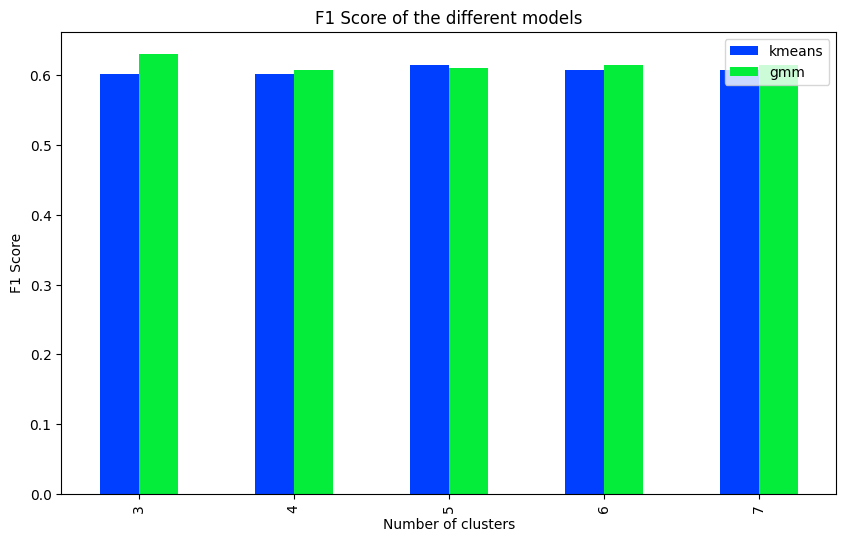

In [38]:
# Compare and plot the results of the different models
fig, ax = plt.subplots(figsize=(10, 6))
df_cp.plot(kind='bar', ax=ax)
plt.title('F1 Score of the different models')
plt.xlabel('Number of clusters')
plt.ylabel('F1 Score')
plt.show()

Review if SMOTE re-sampling helped the model performance. 

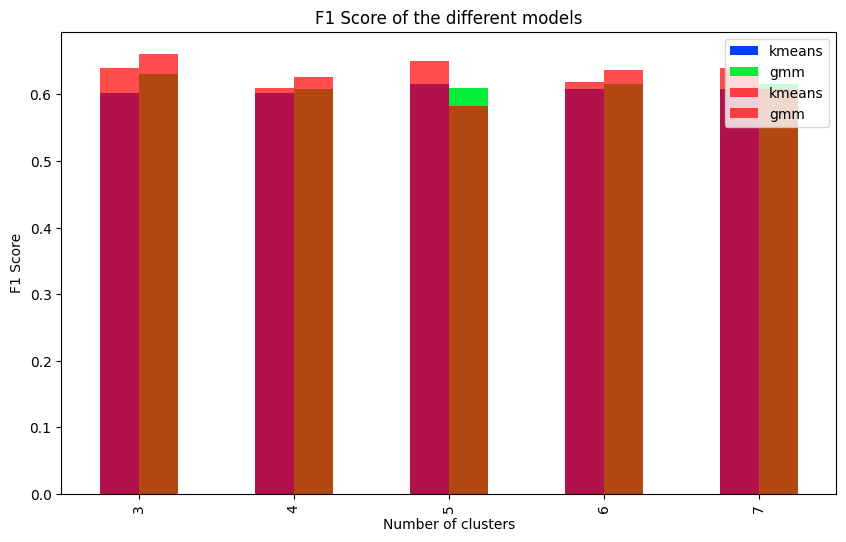

In [39]:
# Compare the results of the pipeline and re-sampling pipeline
fig, ax = plt.subplots(figsize=(10, 6))
df_cp.plot(kind='bar', ax=ax)
df_cr.plot(kind='bar', ax=ax, color='red', alpha=0.7)
plt.title('F1 Score of the different models')
plt.xlabel('Number of clusters')
plt.ylabel('F1 Score')
plt.show()

### Conclusion

The inclusion of customer profiles does not significantly improve the overall model performance pipeline for either model.  There may be some minor improvement depending on the random seed, but since it does not degrade model performance either it can be useful in the context of marketing.  The clusters are customer profiles that are tied to predictive performance.  
>
The re-sampling does help the random forest classifiers obtain similar performance results to SVM in this case.
>
Marketing is not likely to be happy with the results but an important persuasion will be emphasize not continuing to use resources on low opportunity metrics.  